In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from torchvision import utils
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
torch.manual_seed(seed=seed)
torch.set_float32_matmul_precision("high")

if device.type == 'cuda':
    torch.cuda.manual_seed_all(seed=seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(64),
    transforms.Normalize(0.5, 0.5) ## ÌîΩÏÖÄ Í∞íÏùÑ 0.5Î•º ÎπºÍ≥† 0.5Î°ú ÎÇòÎà†Ï§çÎãàÎã§ --> tensor Î≤îÏúÑ [-1,1]
])

train_dataset = datasets.MNIST(root='/home/pervinco/Datasets/MNIST', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='/home/pervinco/Datasets/MNIST', train=False, transform=transform, download=True)

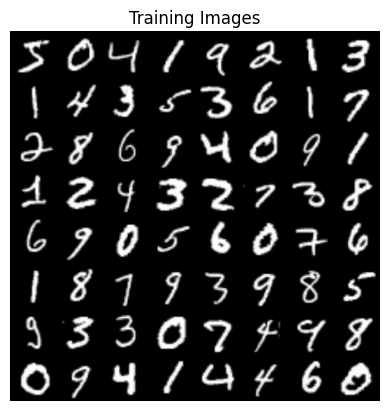

In [4]:
plt.axis('off')
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(torch.cat([train_dataset[i][0].unsqueeze(0) for i in range(64)], dim=0), normalize=True), (1,2,0)))

GANÏùÄ ÏÉùÏÑ±Ïûê(Generator)ÏôÄ ÌåêÎ≥ÑÏûê(Discriminator)Î°ú Íµ¨ÏÑ±Îê©ÎãàÎã§. ÏÉùÏÑ±ÏûêÎäî Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ÏôÄ Ïú†ÏÇ¨Ìïú Îç∞Ïù¥ÌÑ∞Î•º ÏÉùÏÑ±ÌïòÎ†§Í≥† ÌïòÍ≥†, Î∂ÑÎ≥ÑÏûêÎäî Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ÏôÄ ÏÉùÏÑ±ÏûêÍ∞Ä ÏÉùÏÑ±Ìï¥ÎÇ∏ Îç∞Ïù¥ÌÑ∞Î•º Ïûò Íµ¨Î∂ÑÌïòÎ†§Í≥† Ìï©ÎãàÎã§. **GANÏùò Î™©ÌëúÎäî ÌåêÎ≥ÑÏûêÎ•º ÏÜçÏù¥Îäî Ï¢ãÏùÄ ÏÉùÏÑ±ÏûêÎ•º Ï∞æÏïÑ Ïã§Ï†ú Îç∞Ïù¥ÌÑ∞ÏôÄ Ïú†ÏÇ¨Ìïú ÏÉòÌîåÏùÑ ÏÉùÏÑ±Ìï¥ÎÇ¥Îäî Í≤ÉÏûÖÎãàÎã§.**

> DCGANÏùò ÏÉùÏÑ±ÏûêÎ•º Íµ¨ÌòÑÌï¥Î¥ÖÎãàÎã§.

GANÏùò ÏÉùÏÑ±ÏûêÎäî Ïû†Ïû¨ Î≤°ÌÑ∞Î•º ÏûÖÎ†•ÏúºÎ°ú Î∞õÏïÑ Ïù¥ÎØ∏ÏßÄÎ•º Ï∂úÎ†•Ìï©ÎãàÎã§.

![](https://tutorials.pytorch.kr/_images/dcgan_generator.png)

ÏúÑ Í∑∏Î¶ºÏùÄ [DCGAN](https://arxiv.org/pdf/1511.06434.pdf)ÏóêÏÑú 64x64 ÌÅ¨Í∏∞Ïùò Ïù¥ÎØ∏ÏßÄÎ•º ÏÉùÏÑ±ÌïòÍ∏∞ ÏúÑÌïú ÏÉùÏÑ±Ïûê Íµ¨Ï°∞ÏûÖÎãàÎã§. Í∏∞Ï°¥ [Vanilla GANs](https://arxiv.org/pdf/1406.2661.pdf)ÏóêÏÑúÎäî ÌíÄÎßÅ(Pooling)ÏùÑ ÏÇ¨Ïö©ÌñàÎäîÎç∞ Ïù¥Î•º Ìï©ÏÑ±Í≥± Ïã†Í≤ΩÎßùÏúºÎ°ú ÎåÄÏ≤¥ÌïòÏòÄÏäµÎãàÎã§. DCGANÏóêÏÑú Ï∂îÏ≤úÌïú ÏÉùÏÑ±Ïûê Íµ¨Ï°∞Î•º Ï†ïÎ¶¨ÌïòÎ©¥ ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§.

* ÌíÄÎßÅ(Pooling) Î†àÏù¥Ïñ¥ÏôÄ ÏôÑÏ†ÑÏó∞Í≤∞(Fully Connected) Î†àÏù¥Ïñ¥Î•º ÎåÄÏ≤¥ÌïòÏó¨ Ï†ÑÏπò Ìï©ÏÑ±Í≥±(Tranpose Convolution)ÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÍπäÏùÄ Ïã†Í≤ΩÎßùÏùÑ Íµ¨ÏÑ±ÌïúÎã§.
* Ï†ÑÏπò Ìï©ÏÑ±Í≥± Î†àÏù¥Ïñ¥Ïùò Í∞ÄÏ§ëÏπòÎ•º ÌèâÍ∑† 0, ÌëúÏ§ÄÌé∏Ï∞® 0.02Ïù∏ Ï†ïÍ∑úÎ∂ÑÌè¨Î°ú Ï¥àÍ∏∞ÌôîÌïúÎã§.
* Ï∂úÎ†• Ï†Ñ Î†àÏù¥Ïñ¥Î•º Ï†úÏô∏ÌïòÍ≥† Î∞∞Ïπò Ï†ïÍ∑úÌôî(Batchnorm)ÏùÑ ÏÇ¨Ïö©ÌïúÎã§.
* ReLU ÌôúÏÑ±Ìôî Ìï®ÏàòÎ•º ÏÇ¨Ïö©ÌïúÎã§. ÎßàÏßÄÎßâ Ï∂úÎ†•ÏùÑ ÏúÑÌï¥ÏÑúÎäî tanh ÌôúÏÑ±Ìôî Ìï®ÏàòÎ•º ÏÇ¨Ïö©ÌïúÎã§.

Í∑∏Î¶ºÏóêÏÑúÎäî Ïª§ÎÑê ÌÅ¨Í∏∞Í∞Ä 5Î°ú ÎêòÏñ¥ ÏûàÏßÄÎßå, pytorchÏóêÏÑúÎäî Ïª§ÎÑê ÌÅ¨Í∏∞Í∞Ä 4Ïùº Îïå ÌÅ¨Í∏∞Î•º 2Î∞∞Î°ú ÎßåÎì§ Ïàò ÏûàÏäµÎãàÎã§ ([ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) Ï∞∏Í≥†).


‚ùì Ï≤òÏùåÏóê Ïû†Ïû¨ Î≤°ÌÑ∞Îäî Ïù¥ÎØ∏ÏßÄÍ∞Ä ÏïÑÎãåÎç∞ ConvTranspose2d Î™®ÎìàÏùÑ ÏÇ¨Ïö©ÌïòÎäî Ïù¥Ïú†Îäî?
> kÏ∞®Ïõê Ïû†Ïû¨ Î≤°ÌÑ∞ zÎ•º Ï±ÑÎÑêÏù¥ kÍ∞úÏù∏ 1x1 ÌÅ¨Í∏∞ Ïù¥ÎØ∏ÏßÄÎ°ú ÏÉùÍ∞ÅÌï©ÎãàÎã§.

‚ùì ConvTranspose2d Î™®ÎìàÏóêÏÑú bias=FalseÎ°ú ÏßÄÏ†ïÌïòÎäî Ïù¥Ïú†Îäî?
> Î∞∞Ïπò Ï†ïÍ∑úÌôîÎ•º ÏÇ¨Ïö©ÌïòÎØÄÎ°ú Ìï¥Îãπ Î†àÏù¥Ïñ¥Ïùò biasÎäî ÏùòÎØ∏ ÏóÜÏñ¥ÏßëÎãàÎã§.

In [ ]:
class Generator(nn.Module):
    def __init__(self,
                 latent_dim: int=64,
                 base_channels: int=64,
                 out_channels: int=1):

        # nn.ModuleÏùò __init__ Ìï®ÏàòÎ•º Î®ºÏ†Ä Ìò∏Ï∂úÌï¥Ï§çÎãàÎã§
        super().__init__()

        self.model = nn.Sequential(
            # ÏûÖÎ†•: latent_dim x 1 x 1 ÌÅ¨Í∏∞
            nn.ConvTranspose2d(latent_dim, base_channels*8, kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(base_channels*8), # Ï±ÑÎÑê Îã®ÏúÑÎ°ú Ï†ïÍ∑úÌôîÎ•º Ìï¥Ï§çÎãàÎã§
            nn.ReLU(inplace=True),
            # (base_channels*8) x 4 x 4 ÌÅ¨Í∏∞
            nn.ConvTranspose2d(base_channels*8, base_channels*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base_channels*4),
            nn.ReLU(inplace=True),
            # (base_channels*4) x 8 x 8 ÌÅ¨Í∏∞
            nn.ConvTranspose2d(base_channels*4, base_channels*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base_channels*2),
            nn.ReLU(inplace=True),
            # (base_channels*2) x 16 x 16 ÌÅ¨Í∏∞
            nn.ConvTranspose2d(base_channels*2, base_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(inplace=True),
            # (base_channels) x 32 x 32 ÌÅ¨Í∏∞
            nn.ConvTranspose2d(base_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
            # 1 x 64 x 64 ÌÅ¨Í∏∞
        )

    def forward(self, z):
        return self.model(z)

> DCGANÏùò ÌåêÎ≥ÑÏûêÎ•º Íµ¨ÌòÑÌï¥Î¥ÖÎãàÎã§.

ÌåêÎ≥ÑÏûêÎäî Ïù¥ÎØ∏ÏßÄÎ•º ÏûÖÎ†•ÏúºÎ°ú Î∞õÏïÑ ÏßÑÏßúÏù∏ÏßÄ Í∞ÄÏßúÏù∏ÏßÄ ÌåêÎ≥ÑÌï©ÎãàÎã§. ÏÉùÏÑ±ÏûêÏóêÏÑúÏôÄ Î∞òÎåÄÎ°ú Ìï©ÏÑ±Í≥± Ïã†Í≤ΩÎßùÏúºÎ°ú Ï†êÏ∞® Ïù¥ÎØ∏ÏßÄ ÌÅ¨Í∏∞Î•º Ï§ÑÏó¨ÎÇòÍ∞ëÎãàÎã§. ÎßàÏßÄÎßâ Î†àÏù¥Ïñ¥ÏóêÏÑúÎäî ÏãúÍ∑∏Î™®Ïù¥Îìú ÌôúÏÑ±Ìôî Ìï®ÏàòÎ•º Ï†ÅÏö©ÌïòÏó¨ [0,1] Î≤îÏúÑÏùò ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄÍ∞Ä Ïã§Ï†ú Ïù¥ÎØ∏ÏßÄÏùº ÌôïÎ•†ÏùÑ Ï∂úÎ†•Ìï©ÎãàÎã§. [DCGAN](https://arxiv.org/pdf/1511.06434.pdf) ÎÖºÎ¨∏ÏóêÏÑú Ï†úÏïàÌïú ÌåêÎ≥ÑÏûêÏùò Íµ¨Ï°∞Îäî ÏïÑÎûòÏôÄ Í∞ôÏäµÎãàÎã§.

* Ìï©ÏÑ±Í≥±(Convolution) Î†àÏù¥Ïñ¥Îßå ÏÇ¨Ïö©ÌïòÏó¨ ÍπäÏùÄ Ïã†Í≤ΩÎßùÏùÑ Íµ¨ÏÑ±ÌïúÎã§.
* ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞Ïóê Ïó∞Í≤∞Îêú Î†àÏù¥Ïñ¥Î•º Ï†úÏô∏ÌïòÍ≥† Î∞∞Ïπò Ï†ïÍ∑úÌôî(Batchnorm)ÏùÑ Ï†ÅÏö©ÌïúÎã§.
* LeakyReLU ÌôúÏÑ±Ìôî Ìï®ÏàòÎ•º ÏÇ¨Ïö©ÌïúÎã§.

In [ ]:
"""
ÌåêÎ≥ÑÏûê
arguments:
    in_channels: ÏûÖÎ†• Ïù¥ÎØ∏ÏßÄÏùò Ï±ÑÎÑê Í∞úÏàò
    base_channels: Ìï©ÏÑ±Í≥± Ïã†Í≤ΩÎßùÏùò Í∏∞Î≥∏ Ï±ÑÎÑê ÌÅ¨Í∏∞
"""
class Discriminator(nn.Module):
    def __init__(self, in_channels: int=1, base_channels: int=64):
        super().__init__()

        self.model = nn.Sequential(
            # ÏûÖÎ†•: 1 x 64 x 64 ÌÅ¨Í∏∞
            nn.Conv2d(in_channels, base_channels, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # base_channels x 32 x 32 ÌÅ¨Í∏∞
            nn.Conv2d(base_channels, base_channels*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channels*2),
            nn.LeakyReLU(0.2, inplace=True),
            # base_channels x 16 x 16 ÌÅ¨Í∏∞
            nn.Conv2d(base_channels*2, base_channels*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channels*4),
            nn.LeakyReLU(0.2, inplace=True),
            # base_channels x 8 x 8 ÌÅ¨Í∏∞
            nn.Conv2d(base_channels*4, base_channels*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_channels*8),
            nn.LeakyReLU(0.2, inplace=True),
            # base_channels x 4 x 4 ÌÅ¨Í∏∞
            nn.Conv2d(base_channels*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

Ìï©ÏÑ±Í≥± Î†àÏù¥Ïñ¥Ïùò Í∞ÄÏ§ëÏπòÎ•º Ï¥àÍ∏∞ÌôîÌïòÎäî Ìï®ÏàòÎ•º ÏûëÏÑ±Ìï©ÎãàÎã§. ÌèâÍ∑†Ïù¥ 0Ïù¥Í≥† ÌëúÏ§ÄÌé∏Ï∞®Í∞Ä 0.02Ïù∏ Ï†ïÍ∑ú Î∂ÑÌè¨Î°úÎ∂ÄÌÑ∞ Ìï©ÏÑ±Í≥±, Ï†ÑÏπò Ìï©ÏÑ±Í≥± Î†àÏù¥Ïñ¥Ïùò Ï¥àÍ∏∞ Í∞ÄÏ§ëÏπòÎ•º ÏÑ§Ï†ïÌï©ÎãàÎã§.

In [ ]:
"""
Í∞ÄÏ§ëÏπò Ï¥àÍ∏∞Ìôî Ìï®Ïàò: Ìï©ÏÑ±Í≥± ÎòêÎäî Ï†ÑÏπò Ìï©ÏÑ±Í≥± Î†àÏù¥Ïñ¥Ïóê ÎåÄÌï¥ Í∞ÄÏ§ëÏπòÎ•º ÌèâÍ∑† 0, ÌëúÏ§ÄÌé∏Ï∞® 0.02Ïù∏ Ï†ïÍ∑úÎ∂ÑÌè¨ÏóêÏÑú Ï¥àÍ∏∞Ìôî
"""
def weights_init(module):
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
        nn.init.normal_(module.weight.data, 0.0, 0.02) # Í∞ÄÏ§ëÏπòÎ•º ÌèâÍ∑† 0, ÌëúÏ§ÄÌé∏Ï∞® 0.02Ïù∏ Ï†ïÍ∑úÎ∂ÑÌè¨ÏóêÏÑú Ï¥àÍ∏∞Ìôî

```
üí° Ï†ÅÎåÄÏ†Å ÌïôÏäµ(Adversarial Training)ÏùÑ Íµ¨ÌòÑÌïòÍ≥† GANÏùò ÏÜêÏã§Ìï®ÏàòÎ•º Ïñ¥ÎñªÍ≤å Í≥ÑÏÇ∞ÌïòÎäîÏßÄ ÏÇ¥Ìé¥Î¥ÖÎãàÎã§.
```

üìñ (Î≥µÏäµ) GANÏùò ÏÜêÏã§ Ìï®Ïàò
$$
\min_{G}\max_{D} V(D, G) := \mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_Z(z)}[\log (1 - D(G(z)))]
$$

ÏÜêÏã§ Ìï®ÏàòÎ•º Ïñ¥ÎñªÍ≤å Í≥ÑÏÇ∞Ìï† Ïàò ÏûàÏùÑÍπåÏöî?

üìñ ÌåêÎ≥ÑÏûêÏùò ÏÜêÏã§ Ìï®Ïàò

Î®ºÏ†Ä, Ïù¥ÏßÑ Î∂ÑÎ•òÏóêÏÑúÏùò ÌÅ¨Î°úÏä§ ÏóîÌä∏Î°úÌîº(Binary Cross Entropy) ÏÜêÏã§Ìï®ÏàòÎ•º ÏÉùÍ∞ÅÌï¥Î¥ÖÏãúÎã§ ([pytorch Í≥µÏãù Î¨∏ÏÑú - BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#bceloss) Ï∞∏Í≥†). Îç∞Ïù¥ÌÑ∞ $x$ÏôÄ Î†àÏù¥Î∏î $y$Ïóê ÎåÄÌï¥
$$
\ell = - [y \log x + (1 - y) \log (1 - x)] = \begin{cases}
    -\log x & y=1 \\
    -\log (1-x) & y=0
\end{cases}
$$
Î°ú ÎÇòÌÉÄÎÇ©ÎãàÎã§ (ÏïûÏóê $-$Í∞Ä ÏûàÏùåÏóê Ï£ºÏùò). Ïù¥Î•º ÌôúÏö©ÌïòÏó¨ GANÏùò ÏÜêÏã§ Ìï®ÏàòÎ•º Í≥ÑÏÇ∞Ìï† Ïàò ÏûàÏäµÎãàÎã§.

* Ï≤´ Î≤àÏß∏ Ìï≠: Ïã§Ï†ú Ïù¥ÎØ∏ÏßÄ $x$Ïóê ÎåÄÌï¥ $D(x)$Î•º Í≥ÑÏÇ∞ÌïòÍ≥†, Î†àÏù¥Î∏îÏù¥ 1Ïù∏ Í≤ΩÏö∞Ïùò BCELossÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
* Îëê Î≤àÏ®∞ Ìï≠: ÏÉùÏÑ±Îêú Ïù¥ÎØ∏ÏßÄ $G(z)$Ïóê ÎåÄÌï¥ $D(G(z))$Î•º Í≥ÑÏÇ∞ÌïòÍ≥†, Î†àÏù¥Î∏îÏù¥ 0Ïù∏ Í≤ΩÏö∞Ïùò BCELossÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§.


üìñ ÏÉùÏÑ±ÏûêÏùò ÏÜêÏã§ Ìï®Ïàò

Î®ºÏ†Ä, Ï≤´ Î≤àÏß∏ Ìï≠ÏùÄ ÏÉùÏÑ±Ïûê GÏôÄ Í¥ÄÎ†®Ïù¥ ÏóÜÏäµÎãàÎã§. Îëê Î≤àÏß∏ Ìï≠ÏùÑ ÏµúÏÜåÎ°ú ÌïòÎäî Í≥ºÏ†ïÏóêÏÑú Í∏∞Ïö∏Í∏∞ ÏÜåÎ©∏ Î¨∏Ï†ú(Vanishing Gradient Problem)Í∞Ä Î∞úÏÉùÌï† Ïàò ÏûàÏäµÎãàÎã§. ÏÉùÏÑ±ÏûêÎäî ÌåêÎ≥ÑÏûêÍ∞Ä Í∞ÄÏßúÎùºÍ≥† ÌåêÎã®Ìïú(= D(G(x))Í∞Ä 0Ïóê Í∞ÄÍπåÏö¥) Í≤ΩÏö∞Ïóê ÎåÄÌï¥ Í∑∏ÎûòÎîîÏñ∏Ìä∏Í∞Ä ÌÅ¨Í≤å Í≥ÑÏÇ∞ÎêòÏñ¥ ÌåêÎ≥ÑÏûêÎ•º ÏÜçÏù¥Î†§Îäî Î∞©Ìñ•ÏúºÎ°ú ÌïôÏäµÌïòÎäî Í≤ΩÌñ•Ïù¥ Î∞îÎûåÏßÅÌïúÎç∞ $\log (1-x)$Ïùò Í≤ΩÏö∞ 0 Í∑ºÎ∞©ÏóêÏÑú Ï†ëÏÑ†Ïùò Í∏∞Ïö∏Í∏∞Í∞Ä 0Ïóê Í∞ÄÍπùÍ≤å Îê©ÎãàÎã§. Ïù¥Î•º Í∞úÏÑ†ÌïòÏó¨ ÏÉùÏÑ±ÏûêÏùò ÏÜêÏã§ Ìï®ÏàòÎäî ÏµúÏ¢ÖÏ†ÅÏúºÎ°ú
$$
\mathbb{E}_{z \sim p_Z(z)}[- \log D(G(z))]
$$
Í∞Ä Îê©ÎãàÎã§. Ïó¨Í∏∞ÏÑú $- \log x$Îäî 0 Í∑ºÎ∞©ÏóêÏÑú Ï†ëÏÑ†Ïùò Í∏∞Ïö∏Í∏∞Í∞Ä ÌÅ¨Í≥†, 1 Í∑ºÎ∞©ÏóêÏÑú Ï†ëÏÑ†Ïùò Í∏∞Ïö∏Í∏∞Í∞Ä ÏûëÏäµÎãàÎã§. Íµ¨ÌòÑÏùÄ ÌåêÎ≥ÑÏûêÏùò ÏÜêÏã§ Ìï®ÏàòÏùò Ï≤´ Î≤àÏß∏ Ìï≠Í≥º ÎπÑÏä∑ÌïòÍ≤å ÏÉùÏÑ±Îêú Ïù¥ÎØ∏ÏßÄ $G(x)$Ïóê ÎåÄÌï¥ $D(G(x))$Î•º Í≥ÑÏÇ∞ÌïòÍ≥† Î†àÏù¥Î∏îÏù¥ 1Ïù∏ Í≤ΩÏö∞Ïùò BCELossÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§.

In [ ]:
os.makedirs("results", exist_ok = True)

base_channels = 64 # ÏÉùÏÑ±Ïûê, ÌåêÎ≥ÑÏûê Íµ¨Ï°∞Ïùò Í∏∞Î≥∏ Ï±ÑÎÑê Ïàò
batch_size = 128
num_epochs = 20
latent_dim = 32 # Ïû†Ïû¨ Î≤°ÌÑ∞ Ï∞®Ïõê

lr = 0.0002 # ÏÉùÏÑ±ÏûêÏùò ÌïôÏäµÎ•†(learning rate)
lr_adv = 0.0002 # ÌåêÎ≥ÑÏûêÏùò ÌïôÏäµÎ•†
beta1 = 0.5 # Adam optimizerÏùò beta1 ÌååÎùºÎØ∏ÌÑ∞ Í∞í

# Dataloader Ï†ïÏùò
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False)

1. zÎ•º Ï†ïÍ∑úÎ∂ÑÌè¨ÏóêÏÑú ÏÉòÌîåÎßÅÌïúÎã§.
1. ÏÉùÏÑ± Ïù¥ÎØ∏ÏßÄ $G(z)$Î•º Í≥ÑÏÇ∞ÌïúÎã§.
1. ÌåêÎ≥ÑÏûêÏùò ÏÜêÏã§ Ìï®ÏàòÎ•º Í≥ÑÏÇ∞ÌïòÍ≥† ÌåêÎ≥ÑÏûêÎ•º ÏµúÏ†ÅÌôîÌïúÎã§.
1. ÏÉùÏÑ±ÏûêÏùò ÏÜêÏã§ Ìï®ÏàòÎ•º Í≤åÏÇ∞ÌïòÍ≥† ÏÉùÏÑ±ÏûêÎ•º ÏµúÏ†ÅÌôîÌïúÎã§.

ÌåêÎ≥ÑÏûêÏôÄ ÏÉùÏÑ±ÏûêÎ•º ÌïôÏäµÌï† Îïå Î™®Îëê ÏÉùÏÑ±ÏûêÏùò Ï∂úÎ†• Ïù¥ÎØ∏ÏßÄ $G(z)$Í∞Ä ÏÇ¨Ïö©Îê©ÎãàÎã§. ÌåêÎ≥ÑÏûêÎ•º Î®ºÏ†Ä ÌïôÏäµÌï† Îïå [`torch.detach`](https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html) Ìï®ÏàòÎ•º ÏÇ¨Ïö©ÌïòÏó¨ ÏÉùÏÑ±ÏûêÏóê ÎåÄÌï¥ Ïó≠Ï†ÑÌååÍ∞Ä ÏùºÏñ¥ÎÇòÏßÄ ÏïäÎèÑÎ°ù Í∑∏ÎûòÎîîÏñ∏Ìä∏Î•º Í≥ÑÏÇ∞ÌïòÏßÄ ÏïäÎèÑÎ°ù Ìï¥Ïïº Ìï©ÎãàÎã§. `detach` Ìï®ÏàòÎäî ÏûÖÎ†• ÌÖêÏÑúÏùò `requires_grad` ÏòµÏÖòÏùÑ FalseÎ°ú ÎßåÎì§Ïñ¥Ï§çÎãàÎã§. ÏïÑÎûò ÏΩîÎìúÏóêÏÑú `fake_prob = discriminator(fake_data.detach())`ÏôÄ Í∞ôÏù¥ ÎîîÏΩîÎçîÏùò Ï∂úÎ†• `fake_data`Ïóê detach Ìï®ÏàòÎ•º Ï†ÅÏö©Ìï¥Ï£ºÎ©¥ Í∑∏ÎûòÎîîÏñ∏Ìä∏Í∞Ä Í≥ÑÏÇ∞ÎêòÏßÄ ÏïäÍ≤å Îê©ÎãàÎã§. `detach` Ìï®ÏàòÎ•º ÏÇ¨Ïö©ÌïòÏßÄ ÏïäÎäîÎã§Î©¥ ÏÉùÏÑ±ÏûêÏùò ÏÜêÏã§Ìï®ÏàòÏùò backward Í≥ºÏ†ïÏóêÏÑú "Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed)."ÏôÄ Í∞ôÏùÄ ÏóêÎü¨ Î©îÏãúÏßÄÍ∞Ä Îú®Í≤å Îê©ÎãàÎã§. Ïù¥Îäî ÌåêÎ≥ÑÏûêÏùò ÏÜêÏã§ Ìï®ÏàòÎ°úÎ∂ÄÌÑ∞ Í∑∏ÎûòÎîîÏñ∏Ìä∏Î•º Í≥ÑÏÇ∞Ìï† Îïå ÏÉùÏÑ±ÏûêÏóê ÎåÄÌïú Í∑∏ÎûòÎîîÏñ∏Ìä∏Í∞Ä Ïù¥ÎØ∏ Í≥ÑÏÇ∞ÎêòÏñ¥ ÏÉùÏÑ±ÏûêÎ•º ÏóÖÎç∞Ïù¥Ìä∏ÌïòÎ†§Í≥† Ìï† Îïå Ïò§Î•òÍ∞Ä Î∞úÏÉùÌïòÎäî Í≤ÉÏûÖÎãàÎã§.

In [ ]:
# ÏÉùÏÑ±Ïûê & ÌåêÎ≥ÑÏûê Î™®Ìòï
generator = Generator(latent_dim, out_channels=1, base_channels=base_channels).to(device)
discriminator = Discriminator(in_channels=1, base_channels=base_channels).to(device)
generator.apply(weights_init) # Í∞ÄÏ§ëÏπò Ï¥àÍ∏∞Ìôî Ï†ÅÏö©
discriminator.apply(weights_init) # Í∞ÄÏ§ëÏπò Ï¥àÍ∏∞Ìôî Ï†ÅÏö©

# ÏµúÏ†ÅÌôîÍ∏∞ ÏÑ§Ï†ï
optim_g = optim.Adam(generator.parameters(), lr, betas=(beta1, 0.999))
optim_d = optim.Adam(discriminator.parameters(), lr_adv, betas=(beta1, 0.999))

# Ïù¥ÏßÑ ÍµêÏ∞® ÏóîÌä∏Î°úÌîº Ï†ïÏùò
criterion = nn.BCELoss()

In [ ]:
# ÌïôÏäµ Í≥ºÏ†ï (20Î∂Ñ+)

# epoch Îã®ÏúÑÎ°ú loss ÌèâÍ∑†ÏùÑ Í∏∞Î°ùÌï† Î¶¨Ïä§Ìä∏
train_loss_g_epoch, train_loss_d_epoch = [], []
val_loss_g_epoch, val_loss_d_epoch = [], []

fixed_z = torch.randn((64, latent_dim, 1, 1), device=device) # 64Í∞úÏùò Í≥†Ï†ïÎêú Ïû†Ïû¨ Î≤°ÌÑ∞ (ÏÉùÏÑ±Ìï† Îïå ÏÇ¨Ïö©Îê®)

for epoch in range(1, num_epochs+1):
    total_loss_g, total_loss_d = 0., 0. # iterationÎßàÎã§ ÏÜêÏã§ Ìï®ÏàòÏùò ÎàÑÏ†ÅÌï©
    total_num_data = 0 # 1 epochÏóê ÏÇ¨Ïö©Îêú Îç∞Ïù¥ÌÑ∞ Ïàò

    generator.train() # ÌõàÎ†® Î™®ÎìúÎ°ú Î≥ÄÌôò: Î∞∞Ïπò Ï†ïÍ∑úÌôîÏóêÏÑú ÌèâÍ∑†, ÌëúÏ§ÄÌé∏Ï∞®Î•º Í∏∞Î°ùÌï®
    discriminator.train() # ÌõàÎ†® Î™®ÎìúÎ°ú Î≥ÄÌôò: Î∞∞Ïπò Ï†ïÍ∑úÌôîÏóêÏÑú ÌèâÍ∑†, ÌëúÏ§ÄÌé∏Ï∞®Î•º Í∏∞Î°ùÌï®

    # train
    for i, data in enumerate(train_loader):
        real_data = data[0].to(device) # Ïã§Ï†ú Ïù¥ÎØ∏ÏßÄ (Ïù∏Îç±Ïä§ 0: Ïù¥ÎØ∏ÏßÄ / 1: Ïà´Ïûê Î†àÏù¥Î∏î)
        num_data = real_data.size(0) # Î∞∞Ïπò ÌÅ¨Í∏∞
        total_num_data += num_data # Î∞∞Ïπò ÌÅ¨Í∏∞ ÎàÑÏ†ÅÌï©

        # Ïû†Ïû¨ Î≤°ÌÑ∞ ÏÉòÌîåÎßÅÍ≥º Ïù¥ÎØ∏ÏßÄ ÏÉùÏÑ±
        sample_z = torch.randn((num_data, latent_dim, 1, 1), device=device) # ÌëúÏ§ÄÏ†ïÍ∑úÎ∂ÑÌè¨ÏóêÏÑú Ïû†Ïû¨ Î≤°ÌÑ∞ ÏÉòÌîåÎßÅ
        fake_data = generator(sample_z) # Ïù¥ÎØ∏ÏßÄ ÏÉùÏÑ± (ÌåêÎ≥ÑÏûê ÏûÖÏû•ÏóêÏÑú Í∞ÄÏßú Ïù¥ÎØ∏ÏßÄ)

        # BCELoss Í≥ÑÏÇ∞ÏùÑ ÏúÑÌïú Î†àÏù¥Î∏î (real_label: Î™®Îëê 1, fake_label: Î™®Îëê 0)
        real_label = torch.ones(num_data, device=device)
        fake_label = torch.zeros(num_data, device=device)

        # ÌåêÎ≥ÑÏûê ÌïôÏäµ
        # detach() --> fake_data Ïù¥Ï†ÑÏúºÎ°úÎäî Ïó≠Ï†ÑÌåå Í∑∏ÎûòÎîîÏñ∏Ìä∏Î•º Í≥ÑÏÇ∞ÌïòÏßÄ ÏïäÏùå
        #          --> ÏÉùÏÑ±Ïûê ÌååÎùºÎØ∏ÌÑ∞Îäî Í∑∏ÎûòÎîîÏñ∏Ìä∏ = 0
        real_prob = discriminator(real_data).view(-1) # D(x) Í≥ÑÏÇ∞ÌïòÏó¨ 1Ï∞®Ïõê Î≤°ÌÑ∞Î°ú Î≥ÄÌôò
        fake_prob = discriminator(fake_data.detach()).view(-1) # D(G(z)) Í≥ÑÏÇ∞ÌïòÏó¨ 1Ï∞®Ïõê Î≤°ÌÑ∞Î°ú Î≥ÄÌôò
        optim_d.zero_grad()
        # ÌåêÎ≥ÑÏûê ÏÜêÏã§ Ìï®Ïàò Í≥ÑÏÇ∞
        #     Ï≤´ Î≤àÏß∏ Ìï≠: ÌôïÎ•† D(x), Î†àÏù¥Î∏î 1Ïùº ÎïåÏùò bceloss = - log D(x)
        #     Îëê Î≤àÏß∏ Ìï≠: ÌôïÎ•† D(G(z)), Î†àÏù¥Î∏î 0Ïùº ÎïåÏùò bceloss = - log (1 - D(G(z)))
        loss_d = criterion(real_prob, real_label) + criterion(fake_prob, fake_label)
        loss_d.backward()
        optim_d.step() # ÌåêÎ≥ÑÏûê ÏóÖÎç∞Ïù¥Ìä∏

        total_loss_d += loss_d.item() * num_data # ÌåêÎ≥ÑÏûê ÏÜêÏã§ Ìï®Ïàò ÎàÑÏ†ÅÌï©

        # ÏÉùÏÑ±Ïûê ÌïôÏäµ
        # detach() Ï†úÏô∏ --> ÏÉùÏÑ±Ïûê ÌååÎùºÎØ∏ÌÑ∞Ïóê ÎåÄÌï¥ Ïó≠Ï†ÑÌåå Í∑∏ÎûòÎîîÏñ∏Ìä∏ Í≥ÑÏÇ∞ --> ÏÉùÏÑ±Ïûê ÌïôÏäµ
        fake_prob = discriminator(fake_data).view(-1) # D(G(z)) Í≥ÑÏÇ∞ÌïòÏó¨ 1Ï∞®Ïõê Î≤°ÌÑ∞Î°ú Î≥ÄÌôò

        optim_g.zero_grad()
        # ÏÉùÏÑ±Ïûê ÏÜêÏã§ Ìï®Ïàò Í≥ÑÏÇ∞
        #     ÌôïÎ•† D(G(z)), Î†àÏù¥Î∏î 1Ïùº ÎïåÏùò bceloss = - log D(G(z))
        loss_g = criterion(fake_prob, real_label)
        loss_g.backward()
        optim_g.step()

        total_loss_g += loss_g.item() * num_data # ÏÉùÏÑ±Ïûê ÏÜêÏã§ Ìï®Ïàò ÎàÑÏ†ÅÌï©

    # ÏóêÌè≠ Îã®ÏúÑ ÌèâÍ∑† ÏÜêÏã§ Ìï®Ïàò Í∏∞Î°ù
    train_loss_g_epoch.append(total_loss_g / total_num_data)
    train_loss_d_epoch.append(total_loss_d / total_num_data)

    # validation
    val_total_loss_g, val_total_loss_d = 0., 0. # iterationÎßàÎã§ ÏÜêÏã§ Ìï®ÏàòÏùò ÎàÑÏ†ÅÌï©
    val_total_num_data = 0 # 1 epochÏóê ÏÇ¨Ïö©Îêú Îç∞Ïù¥ÌÑ∞ Ïàò

    generator.eval() # Í≤ÄÏ¶ù Î™®ÎìúÎ°ú Î≥ÄÌôò: Î∞∞Ïπò Ï†ïÍ∑úÌôîÏóêÏÑú ÌèâÍ∑†, ÌëúÏ§ÄÌé∏Ï∞®Î•º Í∏∞Î°ùÌïòÏßÄ ÏïäÏùå
    discriminator.eval() # Í≤ÄÏ¶ù Î™®ÎìúÎ°ú Î≥ÄÌôò: Î∞∞Ïπò Ï†ïÍ∑úÌôîÏóêÏÑú ÌèâÍ∑†, ÌëúÏ§ÄÌé∏Ï∞®Î•º Í∏∞Î°ùÌïòÏßÄ ÏïäÏùå

    for data in test_loader:
        real_data = data[0].to(device) # Ïã§Ï†ú Ïù¥ÎØ∏ÏßÄ (Ïù∏Îç±Ïä§ 0: Ïù¥ÎØ∏ÏßÄ / 1: Ïà´Ïûê Î†àÏù¥Î∏î)
        num_data = real_data.size(0) # Î∞∞Ïπò ÌÅ¨Í∏∞
        val_total_num_data += num_data # Î∞∞Ïπò ÌÅ¨Í∏∞ ÎàÑÏ†ÅÌï©

        with torch.no_grad(): # Í∑∏ÎûòÎîîÏñ∏Ìä∏ Í≥ÑÏÇ∞ X
            # Ïû†Ïû¨ Î≤°ÌÑ∞ ÏÉòÌîåÎßÅÍ≥º Ïù¥ÎØ∏ÏßÄ ÏÉùÏÑ±
            sample_z = torch.randn((num_data, latent_dim, 1, 1), device=device) # ÌëúÏ§ÄÏ†ïÍ∑úÎ∂ÑÌè¨ÏóêÏÑú Ïû†Ïû¨ Î≤°ÌÑ∞ ÏÉòÌîåÎßÅ
            fake_data = generator(sample_z) # Ïù¥ÎØ∏ÏßÄ ÏÉùÏÑ± (ÌåêÎ≥ÑÏûê ÏûÖÏû•ÏóêÏÑú Í∞ÄÏßú Ïù¥ÎØ∏ÏßÄ)

            # BCELoss Í≥ÑÏÇ∞ÏùÑ ÏúÑÌïú Î†àÏù¥Î∏î (real_label: Î™®Îëê 1, fake_label: Î™®Îëê 0)
            real_label = torch.ones(num_data, device=device)
            fake_label = torch.zeros(num_data, device=device)

            # ÌåêÎ≥ÑÏûê ÏÜêÏã§ Ìï®Ïàò
            real_prob = discriminator(real_data).view(-1)
            fake_prob = discriminator(fake_data.detach()).view(-1)
            loss_d = criterion(real_prob, real_label) + criterion(fake_prob, fake_label) # ÌåêÎ≥ÑÏûê ÏÜêÏã§ Ìï®Ïàò Í≥ÑÏÇ∞
            val_total_loss_d += loss_d.item() * num_data # ÌåêÎ≥ÑÏûê ÏÜêÏã§ Ìï®Ïàò ÎàÑÏ†ÅÌï©

            # ÏÉùÏÑ±Ïûê ÏÜêÏã§ Ìï®Ïàò
            fake_prob = discriminator(fake_data).view(-1)
            loss_g = criterion(fake_prob, real_label) # ÏÉùÏÑ±Ïûê ÏÜêÏã§ Ìï®Ïàò Í≥ÑÏÇ∞
            val_total_loss_g += loss_g.item() * num_data # ÏÉùÏÑ±Ïûê ÏÜêÏã§ Ìï®Ïàò ÎàÑÏ†ÅÌï©

    # 64Í∞úÏùò Í≥†Ï†ïÎêú Ïû†Ïû¨ Î≤°ÌÑ∞Ïóê ÎåÄÌïú ÏÉùÏÑ± Í≤∞Í≥ºÎ•º results Ìè¥ÎçîÏóê Ï†ÄÏû•
    plt.axis('off')
    plt.title("Generated samples")
    plt.imshow(np.transpose(utils.make_grid(generator(fixed_z).detach().cpu(), normalize=True), (1,2,0)))
    plt.savefig(f'results/gen_epoch{epoch}.png')

    val_loss_g_epoch.append(val_total_loss_g / val_total_num_data)
    val_loss_d_epoch.append(val_total_loss_d / val_total_num_data)

    # ÏÜêÏã§ Ìï®Ïàò Ï∂úÎ†•
    # f-string 02d ÏòµÏÖò: 2ÏûêÎ¶¨ Ï†ïÏàò Ï∂úÎ†• / 1.4f ÏòµÏÖò: Ï†ïÏàò Î∂ÄÎ∂Ñ 1ÏûêÎ¶¨, ÏÜåÏàò Î∂ÄÎ∂Ñ 4ÏûêÎ¶¨ Ï∂úÎ†•
    print(
        f"[{epoch:02d}/{num_epochs:02d}] loss_d: {total_loss_d / total_num_data:1.4f}\tloss_g: {total_loss_g / total_num_data:1.4f}" \
        + f"\tval_loss_d: {val_total_loss_d / val_total_num_data:1.4f}\tval_loss_g: {val_total_loss_g / val_total_num_data:1.4f}"
    )

In [ ]:
plt.figure(figsize=(10,4)) # Í∑∏Î¶ºÌåê ÌÅ¨Í∏∞ Ï°∞Ï†à
plt.subplot(121) # 121 = 1Ìñâ 2Ïó¥ Í∑∏Î¶º Ï§ë Ï≤´ Î≤àÏß∏ Í∑∏Î¶º
plt.title("Discriminator loss") # ÌåêÎ≥ÑÏûê ÏÜêÏã§ Ìï®Ïàò Í∑∏ÎûòÌîÑ
plt.plot(train_loss_d_epoch, label="train")
plt.plot(val_loss_d_epoch, label="valid")
plt.legend()

plt.subplot(122) # 122 = 1Ìñâ 2Ïó¥ Í∑∏Î¶º Ï§ë Îëê Î≤àÏß∏ Í∑∏Î¶º
plt.title("Generator loss") # ÏÉùÏÑ±Ïûê ÏÜêÏã§ Ìï®Ïàò Í∑∏ÎûòÌîÑ
plt.plot(train_loss_g_epoch, label="train")
plt.plot(val_loss_g_epoch, label="valid")
plt.legend()

plt.show()

## ÏÉùÏÑ± Î™®Îç∏ ÌèâÍ∞Ä: Inception Score

```
üí° Inception Score(IS)Î•º Í≥ÑÏÇ∞ÌïòÏó¨ ÏÉùÏÑ± Î™®Îç∏ÏùÑ ÌèâÍ∞ÄÌï¥Î¥ÖÎãàÎã§.
```

IS Í≥ÑÏÇ∞ Ï†àÏ∞®:

1. MNIST Ïà´Ïûê Î∂ÑÎ•òÍ∏∞ ÌïôÏäµ
1. ÏÉùÏÑ± Ïù¥ÎØ∏ÏßÄÎ•º Î∂ÑÎ•ò
1. IS Í≥ÑÏÇ∞

Inception Score(Ïù¥Ìïò IS)Îäî ÏòàÎ¶¨Ìï®(Sharpness)Í≥º Îã§ÏñëÏÑ±(Diversity)Ïùò Í≥±ÏúºÎ°ú Í≥ÑÏÇ∞Îê©ÎãàÎã§. Ïó¨Í∏∞ÏÑú, ÏòàÎ¶¨Ìï®ÏùÄ Ïà´ÏûêÎ•º Î™ÖÌôïÌûà ÏÉùÏÑ±ÌïòÏó¨ Î∂ÑÎ•òÍ∏∞Í∞Ä Ìï¥Îãπ Ïà´ÏûêÎ•º Ïûò ÏòàÏ∏°ÌïòÎäî Í≤ÉÏùÑ ÏùòÎØ∏ÌïòÍ≥† Îã§ÏñëÏÑ±ÏùÄ Îã§ÏñëÌïú Ïà´ÏûêÎ•º ÏÉùÏÑ±ÌïòÎäî Í≤ÉÏùÑ ÎúªÌï©ÎãàÎã§. ISÎäî ÏÉùÏÑ± Ïù¥ÎØ∏ÏßÄÎßå Ïù¥Ïö©ÌïòÏó¨ Í≥ÑÏÇ∞ÌïòÎ©∞ Î®ºÏ†Ä Î∂ÑÎ•òÍ∏∞Î•º ÌÜµÌï¥ Ïñ¥Îñ§ Ïà´Ïûê Ïù¥ÎØ∏ÏßÄÏù∏ÏßÄ Î∂ÑÎ•òÌï©ÎãàÎã§. Ï†ÑÏ≤¥ ÏÉùÏÑ± Ïù¥ÎØ∏ÏßÄÎì§Ïù¥ 0~9 Ïà´ÏûêÎ•º Ïñ¥Îñ§ ÎπÑÏú®Î°ú ÏÉùÏÑ±ÎêêÎäîÏßÄ Í≥ÑÏÇ∞ÌïòÍ≥†(=$q(y)$) Ïù¥Î•º Í∏∞Ï§ÄÏúºÎ°ú ÏÉùÏÑ± Ïù¥ÎØ∏ÏßÄÏùò Ïà´Ïûê Î∂ÑÎ•ò ÌôïÎ•†(=$q(y|x)$)ÏôÄ Ïø®Î∞±-ÎùºÏù¥Î∏îÎü¨ Í±∞Î¶¨Î•º Í≥ÑÏÇ∞ÌïòÍ≤å Îê©ÎãàÎã§.
$$
\begin{aligned}
IS &= \exp (\mathbb{E}_{x \sim p_{\theta}(x)}KL(q(y|x) \Vert q(y)) \\
&= \exp \left( \mathbb{E}_{x \sim p_{\theta}(x)} \sum_{y} \big[ q(y|x) \log q(y|x) - q(y|x) \log q(y) \big] \right)
\end{aligned}
$$

Inception ScoreÎäî ÏÇ¨Ï†ÑÌõàÎ†®Îêú Inception-V3 Î™®Îç∏ÏùÑ Î∂ÑÎ•òÍ∏∞Î•º ÌôúÏö©ÌïòÏó¨ Í≥ÑÏÇ∞ÌïòÏßÄÎßå Î≥∏ Ïã§ÏäµÏóêÏÑúÎäî MNIST Ïà´Ïûê Î∂ÑÎ•òÍ∏∞Î•º ÌïôÏäµÌïòÏó¨ ISÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§.

In [ ]:
# ÏÑ†Ìòï Î†àÏù¥Ïñ¥Î•º ÏåìÏùÄ Ïà´Ïûê Î∂ÑÎ•òÍ∏∞Î•º ÎßåÎì≠ÎãàÎã§
digits_classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(4096, 256),
    nn.Dropout(p=0.2, inplace=True),
    nn.ReLU(inplace=True),
    nn.Linear(256, 256),
    nn.Dropout(p=0.2, inplace=True),
    nn.ReLU(inplace=True),
    nn.Linear(256, 10)
).to(device)

# RMSProp ÏµúÏ†ÅÌôîÍ∏∞Î•º ÏÑ§Ï†ïÌï©ÎãàÎã§
optim_clf = optim.RMSprop(digits_classifier.parameters(), lr=5e-4)

# ÌÅ¨Î°úÏä§ ÏóîÌä∏Î°úÌîº ÏÜêÏã§ Ìï®ÏàòÎ•º Ï†ïÏùòÌï©ÎãàÎã§.
ce = nn.CrossEntropyLoss()

for epoch in range(10):
    total_loss = 0. # ÏóêÌè≠ Îã®ÏúÑ ÏÜêÏã§ Ìï®Ïàò ÎàÑÏ†ÅÌï©
    # num_data: ÏóêÌè≠ Îã®ÏúÑ Îç∞Ïù¥ÌÑ∞ Ïàò / num_correct: ÏóêÌè≠ Îã®ÏúÑ Î†àÏù¥Î∏îÏùÑ ÎßûÏ∂ò Îç∞Ïù¥ÌÑ∞ Ïàò
    num_data, num_correct = 0, 0

    digits_classifier.train() # ÌïôÏäµ Î™®Îìú: Dropout ÌôúÏÑ±Ìôî

    # train
    for data in train_loader:
        image = data[0].to(device)
        label = data[1].to(device)

        logits = digits_classifier(image) # Î°úÏßì Í≥ÑÏÇ∞
        optim_clf.zero_grad()
        loss = ce(logits, label.long()) # ÌÅ¨Î°úÏä§ ÏóîÌä∏Î°úÌîº Í≤åÏÇ∞
        loss.backward()
        optim_clf.step() # Î∂ÑÎ•òÍ∏∞ ÌïôÏäµ

        total_loss += loss.item() * len(label) # ÏÜêÏã§ Ìï®Ïàò ÎàÑÏ†ÅÌï©
        num_data += len(label) # Îç∞Ïù¥ÌÑ∞ Ïàò ÎàÑÏ†ÅÌï©
        # Î†àÏù¥Î∏î ÎßûÏ∂ò Îç∞Ïù¥ÌÑ∞ Ïàò ÎàÑÏ†ÅÌï©
        #     logits.argmax(dim=1): 10Ï∞®Ïõê Î∂ÑÎ•òÍ∏∞ Ï∂úÎ†• Ï§ë Í∞ÄÏû• Î°úÏßìÏù¥ ÌÅ∞ Ïù∏Îç±Ïä§Î°ú ÏòàÏ∏° Î†àÏù¥Î∏î Í≥ÑÏÇ∞
        num_correct += (logits.argmax(dim=1) == label).sum().item()


    val_total_loss = 0. # ÏóêÌè≠ Îã®ÏúÑ ÏÜêÏã§ Ìï®Ïàò ÎàÑÏ†ÅÌï©
    # num_data: ÏóêÌè≠ Îã®ÏúÑ Îç∞Ïù¥ÌÑ∞ Ïàò / num_correct: ÏóêÌè≠ Îã®ÏúÑ Î†àÏù¥Î∏îÏùÑ ÎßûÏ∂ò Îç∞Ïù¥ÌÑ∞ Ïàò
    val_num_data, val_num_correct = 0, 0

    digits_classifier.eval() # Í≤ÄÏ¶ù Î™®Îìú: Dropout ÎπÑÌôúÏÑ±Ìôî

    for data in test_loader:
        image = data[0].to(device)
        label = data[1].to(device)

        logits = digits_classifier(image)
        val_loss = ce(logits, label.long()) # ÏÜêÏã§Ìï®Ïàò Í≥ÑÏÇ∞

        # ÏÜêÏã§Ìï®Ïàò, Îç∞Ïù¥ÌÑ∞ Ïàò, Î†àÏù¥Î∏î ÎßûÏ∂ò Îç∞Ïù¥ÌÑ∞ Ïàò ÎàÑÏ†ÅÌï© Í≥ÑÏÇ∞
        val_total_loss += val_loss.item() * len(label)
        val_num_data += len(label)
        val_num_correct += (logits.argmax(dim=1) == label).sum().item()

    # ÏÜêÏã§ Ìï®Ïàò, ÏòàÏ∏° Ï†ïÌôïÎèÑ Ï∂úÎ†•
    print(
        f"[{epoch+1:02d}/10] loss: {total_loss / num_data:1.6f}\taccuracy: {num_correct / num_data:1.6f}" \
        +f"\tval_loss: {val_total_loss / val_num_data:1.6f}\tval_accuracy: {val_num_correct / val_num_data:1.6f}"
    )

[01/10] loss: 0.507963	accuracy: 0.856450	val_loss: 0.247519	val_accuracy: 0.921800
[02/10] loss: 0.229859	accuracy: 0.929383	val_loss: 0.184883	val_accuracy: 0.940100
[03/10] loss: 0.180052	accuracy: 0.945267	val_loss: 0.129459	val_accuracy: 0.961500
[04/10] loss: 0.156070	accuracy: 0.951583	val_loss: 0.098400	val_accuracy: 0.969600
[05/10] loss: 0.135461	accuracy: 0.957650	val_loss: 0.111889	val_accuracy: 0.965000
[06/10] loss: 0.124011	accuracy: 0.960883	val_loss: 0.076089	val_accuracy: 0.975600
[07/10] loss: 0.116138	accuracy: 0.964117	val_loss: 0.077362	val_accuracy: 0.974900
[08/10] loss: 0.108056	accuracy: 0.966100	val_loss: 0.088269	val_accuracy: 0.970500
[09/10] loss: 0.102581	accuracy: 0.967450	val_loss: 0.081485	val_accuracy: 0.973900
[10/10] loss: 0.097379	accuracy: 0.969483	val_loss: 0.073344	val_accuracy: 0.975900


ÌïôÏäµÎêú Ïà´Ïûê Î∂ÑÎ•òÍ∏∞Ïùò ÏòàÏ∏° Ï†ïÌôïÎèÑÎäî 97% Ïù¥ÏÉÅÏûÖÎãàÎã§. Ïù¥Ï†ú 5ÎßåÍ∞úÏùò Ïù¥ÎØ∏ÏßÄÎ•º ÏÉùÏÑ±ÌïòÍ≥† Inception scoreÎ•º Í≥ÑÏÇ∞Ìï©ÎãàÎã§. ÏÉùÏÑ± Ïù¥ÎØ∏ÏßÄÎì§Ïùò Î†àÏù¥Î∏î Î∂ÑÌè¨ $q(y)$Îäî 5ÎßåÍ∞ú ÏÉùÏÑ± Ïù¥ÎØ∏ÏßÄÏóê ÎåÄÌï¥ $q(y|x)$Î•º ÌèâÍ∑†ÎÇ¥Ïñ¥ Í≥ÑÏÇ∞Ìï©ÎãàÎã§.


In [ ]:
num_samples = 10000

# ÏÉùÏÑ±ÏûêÏôÄ Ïà´Ïûê Î∂ÑÎ•òÍ∏∞ Í≤ÄÏ¶ù Î™®ÎìúÎ°ú Ï†ÑÌôò
generator.eval()
digits_classifier.eval()

# 5ÎßåÍ∞ú Ïù¥ÎØ∏ÏßÄ ÏÉùÏÑ±
gen_images = generator(torch.randn((num_samples, latent_dim, 1, 1), device="cuda"))

ÏÉùÏÑ±Ìïú Ïù¥ÎØ∏ÏßÄÎ•º ÏãúÍ∞ÅÌôîÌï¥Î¥ÖÎãàÎã§.

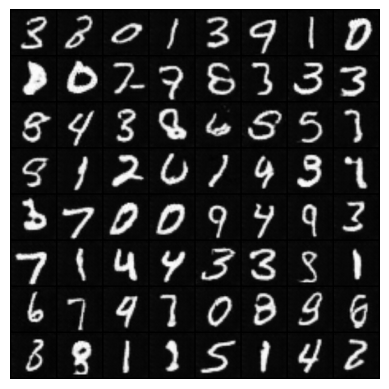

In [ ]:
plt.axis('off')
plt.imshow(np.transpose(utils.make_grid(gen_images[0:64].cpu(), normalize=True),(1,2,0)))

ÏÑ†Î™ÖÌïú Ïà´ÏûêÎì§Ïù¥ ÏÉùÏÑ±ÎêúÍ≤ÉÏùÑ ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

In [ ]:
# ÏòàÏ∏° ÌôïÎ•† Í≥ÑÏÇ∞ (softmaxÎ•º Ï†ÅÏö©Ìï¥ Î°úÏßìÏùÑ ÌôïÎ•†Î°ú Î≥ÄÌôò)
y_pred = torch.softmax(digits_classifier(gen_images.cuda()), dim=1).detach().cpu() # 50000 x 10 Ï∞®Ïõê
q_y = y_pred.mean(dim = 0) # q(y) Í≥ÑÏÇ∞: Í∞Å ÏÉùÏÑ± Ïù¥ÎØ∏ÏßÄÏùò ÏòàÏ∏° ÌôïÎ•†Ïùò ÌèâÍ∑† # 1 x 10Ï∞®Ïõê

# Inception score Í≥ÑÏÇ∞:
#     ISÏùò Ï≤´ Î≤àÏß∏ Ìï≠ÏùÑ Í≥ÑÏÇ∞ÌïòÎ†§Î©¥ Î®ºÏ†Ä Í∞Å Ïù¥ÎØ∏ÏßÄ(x)Ïóê ÎåÄÌï¥ q(y|x) log q(y|x)Î•º Î™®Îì† y(0~9)Ïóê ÎåÄÌï¥ Ìï©Ï≥êÏïº ÌïòÎØÄÎ°ú
#     .sum(dim=1) Ìï®ÏàòÎ•º Ïù¥Ïö©ÌïòÏó¨ Îëê Î≤àÏß∏ Ï∞®ÏõêÏóê ÎåÄÌï¥ Ìï©ÏùÑ Î®ºÏ†Ä Í≥ÑÏÇ∞Ìï©ÎãàÎã§.
#     Ïù¥ÌõÑ Î™®Îì† xÏóê ÎåÄÌï¥ ÌèâÍ∑†ÏùÑ Ï∑®Ìï¥Ï£ºÎ©¥ Îê©ÎãàÎã§.
log_is = (y_pred * y_pred.log()).sum(dim=1).mean() - (y_pred * q_y.log()).sum(dim=1).mean()
print("IS score:", log_is.exp().item())

IS score: 7.729973793029785


- (Ï∞∏Í≥†) [torchmetric.image.inception.InceptionScore](https://torchmetrics.readthedocs.io/en/stable/image/inception_score.html) : `torchmetrics` Ìå®ÌÇ§ÏßÄÎ•º Ïù¥Ïö©ÌïòÎ©¥ Inception-V3 Î™®Îç∏ÏùÑ Î∂ÑÎ•òÍ∏∞Î°ú ÌôúÏö©Ìïú Inception ScoreÎ•º ÏâΩÍ≤å Í≥ÑÏÇ∞Ìï† Ïàò ÏûàÏäµÎãàÎã§.